In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, rospy, rosbag, glob, re

import scipy
import scipy.stats
from scipy.stats import pearsonr

from smap.msg import smapStats

import matplotlib.cm as cm
from matplotlib.colors import LogNorm

Computing mask from round 0...
(32768,)
Computed mask: 1842 of 32768 voxels are correctly predicted by SMAP at last step.
Computing mask from round 1...
(32768,)
Computed mask: 1750 of 32768 voxels are correctly predicted by SMAP at last step.
Computing mask from round 2...
(32768,)
Computed mask: 1690 of 32768 voxels are correctly predicted by SMAP at last step.
Computing mask from round 3...
(32768,)
Computed mask: 1661 of 32768 voxels are correctly predicted by SMAP at last step.
Computing mask from round 4...
(32768,)
Computed mask: 1630 of 32768 voxels are correctly predicted by SMAP at last step.
Computing mask from round 5...
(32768,)
Computed mask: 1609 of 32768 voxels are correctly predicted by SMAP at last step.
Computing mask from round 6...
(32768,)
Computed mask: 1592 of 32768 voxels are correctly predicted by SMAP at last step.
Computed mask: 1592 of 32768 voxels are correctly predicted by SMAP at last step.
Evaluating round 0 (../build/repeated_fake_3d_2/stats_0.bag)...


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


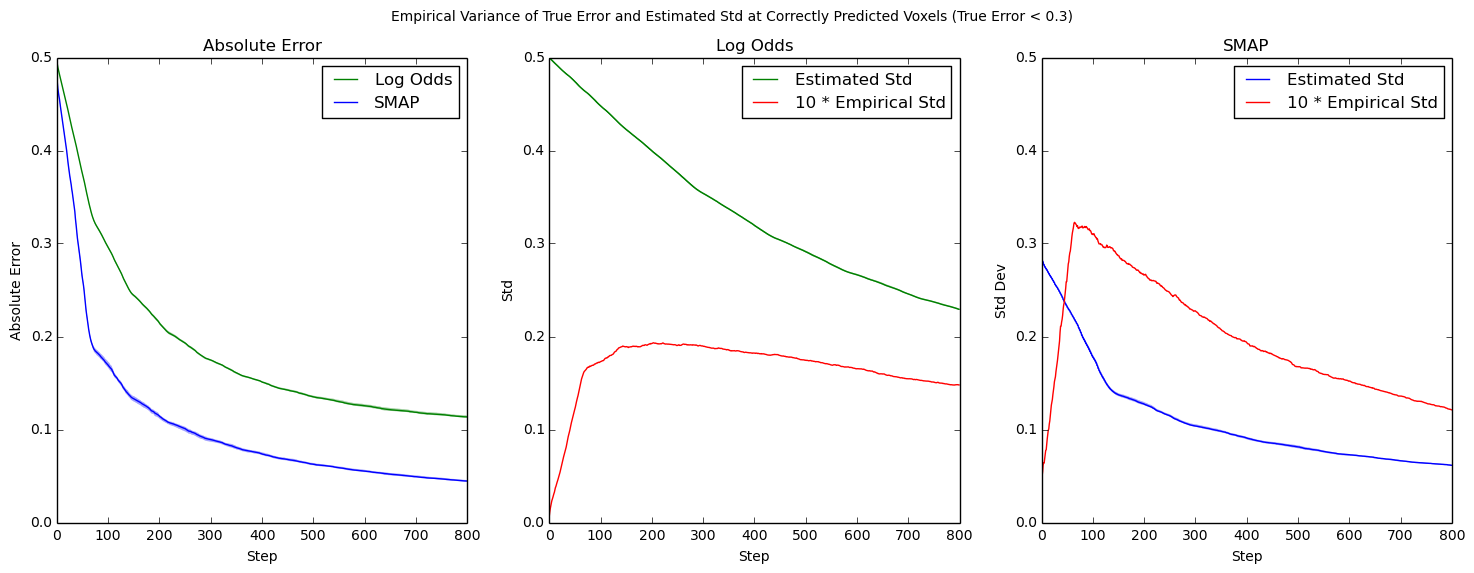

In [4]:
%matplotlib inline
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Empirical Variance of True Error and Estimated Std at Correctly Predicted Voxels (True Error < 0.3)")

# size is rounds * step
updated_voxels = []
err_belief = []
std_belief = []
err_logodds = []
std_logodds = []

steps = 0
voxels = 0

last_stats = None

# see octomap::OcTreeKey::KeyHash
def hash_position(x, y, z):
    return "%.3f %.3f %.3f" % (x, y, z)

filenames = sorted(
    glob.glob("../build/repeated_fake_3d_2/*.bag"),
    key=lambda f: int(re.findall('([0-9]+)', f[len("../build/repeated_fake_3d_2/"):])[0]))


mask = None
for rnd, filename in enumerate(filenames):
    print "Computing mask from round %i..." % rnd
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue
    voxels = stats.voxels
        
    errLogOdds = np.abs(np.array(stats.errorCompleteLogOdds[-stats.voxels:]))
    errBelief = np.abs(np.array(stats.errorCompleteBelief[-stats.voxels:]))
    print errBelief.shape
    if rnd == 0:
        mask = (errBelief < .3)
    else:
        mask = mask & (errBelief < .3)
    print "Computed mask: %i of %i voxels are correctly predicted by SMAP at last step." \
        % (len(filter(lambda x: x > 0, mask)), voxels)
        
print "Computed mask: %i of %i voxels are correctly predicted by SMAP at last step." \
        % (len(filter(lambda x: x > 0, mask)), voxels)
    
for rnd, filename in enumerate(filenames):
    print "Evaluating round %i (%s)..." % (rnd, filename)
    bag = rosbag.Bag(filename)
    stats = None
    for _, msg, _ in bag.read_messages(topics=['stats']):
        stats = msg
    bag.close()
    if stats is None:
        continue
        
    steps = stats.step
    last_stats = stats
    
#     updated_voxels_step = []
#     start = 0
#     for step in range(stats.step):
#         step_voxels = []
#         for voxel in range(stats.updatedVoxels[step]):
#             step_voxels.append((voxel, hash_position(stats.updatedVoxelsX[start + voxel],
#                                              stats.updatedVoxelsY[start + voxel],
#                                              stats.updatedVoxelsZ[start + voxel])))
#         updated_voxels_step.append(step_voxels)
#         start += stats.voxels
#     updated_voxels.append(updated_voxels_step)    
        
    start = 0
    
    err_belief_rnd = []
    std_belief_rnd = []
    err_logodds_rnd = []
    std_logodds_rnd = []    
    
    for step in range(stats.step):
        # Problem: because of [err < .3], we don't select the same voxel indices anymore for every round!
        err = np.abs(np.array(stats.errorCompleteLogOdds[start:start + stats.voxels]))
        err_belief_rnd.append(
            np.abs(np.array(stats.errorCompleteBelief[start:start + stats.voxels])[mask]))
        std_belief_rnd.append(
            np.array(stats.stdCompleteBelief[start:start + stats.voxels])[mask])
        std_logodds_rnd.append(
            np.array(stats.stdCompleteLogOdds[start:start + stats.voxels])[mask])
        err_logodds_rnd.append(err[mask])
#        err = np.array(stats.errorCompleteLogOdds[start:start + stats.voxels])
#        err_belief_rnd.append(
#            np.array(stats.errorCompleteBelief[start:start + stats.voxels]))
#        std_belief_rnd.append(
#            np.array(stats.stdCompleteBelief[start:start + stats.voxels]))
#        std_logodds_rnd.append(
#            np.array(stats.stdCompleteLogOdds[start:start + stats.voxels]))
#        err_logodds_rnd.append(err)
                
        start += stats.voxels
        
    err_belief.append(err_belief_rnd)
    std_belief.append(std_belief_rnd)
    err_logodds.append(err_logodds_rnd)
    std_logodds.append(std_logodds_rnd)
 

var_err_belief = []
var_std_belief = []
var_err_logodds = []
var_std_logodds = []
min_err_belief = []
max_err_belief = []
min_std_belief = []
max_std_belief = []
min_err_logodds = []
max_err_logodds = []
min_std_logodds = []
max_std_logodds = []
avg_err_belief = []
avg_std_belief = []
avg_err_logodds = []
avg_std_logodds = []
for step in range(steps):
#     print "Updating for step", step
#     updated = [updated_voxels[rnd][step] for rnd in range(len(filenames))]
#     positions = [map(lambda x: x[1], vs) for vs in updated]
#     unique = reduce(set.intersection, map(set, positions))
#     indices = [[x[0] for x in vs if x[1] in unique] for vs in updated]
    
#     print "step:", step, " \tunique:", len(unique), " \tupdated:", len(updated[0])
    
#     if step == 100 or step == 200:
# #         print "updated:  ", updated
#         print "\n\n\n", step
#         print "positions:", positions
#         print "\n\n\n", step
#         print "unique:   ", unique
#         print "indices:  ", indices
    
    var_err_step_belief = []
    var_std_step_belief = []
    var_err_step_logodds = []
    var_std_step_logodds = []
    min_err_belief.append(min([np.mean(err_belief[rnd][step]) for rnd in range(len(filenames))]))
    max_err_belief.append(max([np.mean(err_belief[rnd][step]) for rnd in range(len(filenames))]))
    min_std_belief.append(min([np.mean(std_belief[rnd][step]) for rnd in range(len(filenames))]))
    max_std_belief.append(max([np.mean(std_belief[rnd][step]) for rnd in range(len(filenames))]))
    min_err_logodds.append(min([np.mean(err_logodds[rnd][step]) for rnd in range(len(filenames))]))
    max_err_logodds.append(max([np.mean(err_logodds[rnd][step]) for rnd in range(len(filenames))]))
    min_std_logodds.append(min([np.mean(std_logodds[rnd][step]) for rnd in range(len(filenames))]))
    max_std_logodds.append(max([np.mean(std_logodds[rnd][step]) for rnd in range(len(filenames))]))
    avg_err_belief.append(sum([np.mean(err_belief[rnd][step]) for rnd in range(len(filenames))]) / len(filenames))
    avg_std_belief.append(sum([np.mean(std_belief[rnd][step]) for rnd in range(len(filenames))]) / len(filenames))
    avg_err_logodds.append(sum([np.mean(err_logodds[rnd][step]) for rnd in range(len(filenames))]) / len(filenames))
    avg_std_logodds.append(sum([np.mean(std_logodds[rnd][step]) for rnd in range(len(filenames))]) / len(filenames))
    # iterate over voxels, problem: here we are computing std of voxels and not rounds!
#     print "len(err_belief[0][step]) = ", len(err_belief[0][step])
#     print "len(err_logodds[0][step]) = ", len(err_logodds[0][step])
#     print "np.std([err_belief[rnd][step][voxeli] for rnd in range(len(filenames))])", err_belief[0][step][5]
    min_length = min(map(len, [err_belief[rnd][step] for rnd in range(len(filenames))]))
    var_err_belief.append(np.mean([np.std([err_belief[rnd][step][voxeli] for rnd in range(len(filenames))])
                                      for voxeli in range(min_length)]))
    min_length = min(map(len, [err_logodds[rnd][step] for rnd in range(len(filenames))]))
    var_err_logodds.append(np.mean([np.std([err_logodds[rnd][step][voxeli] for rnd in range(len(filenames))])
                                      for voxeli in range(min_length)]))
    
def moving_average(array, n=10):
    return np.convolve(array, np.ones(n) / n)

x = list(range(steps))
ax1.fill_between(x, min_err_belief, max_err_belief, alpha=0.2, facecolor='b', edgecolor='none', antialiased=True)
ax1.fill_between(x, min_err_logodds, max_err_logodds, alpha=0.2, facecolor='g', edgecolor='none', antialiased=True)
ax1.fill_between(x, min_err_belief, max_err_belief, alpha=0.2, facecolor='b', edgecolor='none', antialiased=True)
ax1.fill_between(x, min_err_logodds, max_err_logodds, alpha=0.2, facecolor='g', edgecolor='none', antialiased=True)
ax1.plot(avg_err_logodds, color="g", label="Log Odds")
ax1.plot(avg_err_belief, color="b", label="SMAP")

ax1.set_xlabel("Step")
ax1.set_ylabel("Absolute Error")
ax1.set_title("Absolute Error")
ax1.legend()
ax1.set_xlim([0, steps])

ax2.fill_between(x, min_std_logodds, max_std_logodds, alpha=0.2, facecolor='g', edgecolor='none', antialiased=True)
ax2.fill_between(x, min_std_logodds, max_std_logodds, alpha=0.2, facecolor='g', edgecolor='none', antialiased=True)
ax2.plot(avg_std_logodds, color="g", label="Estimated Std")
ax2.plot(np.array(var_err_logodds) * 10., label="10 * Empirical Std", color="r")
ax2.set_xlabel("Step")
ax2.set_ylabel("Std")
ax2.set_title("Log Odds") 
ax2.set_xlim([0, steps])
ax2.set_ylim([0, .5])
ax2.legend()

# ax3.plot(moving_average(var_err_belief), label="SMAP Moving AVG")
# ax3.plot(moving_average(var_err_logodds), label="Log Odds Moving AVG")

ax3.fill_between(x, min_std_belief, max_std_belief, alpha=0.2, facecolor='b', edgecolor='none', antialiased=True)
ax3.fill_between(x, min_std_belief, max_std_belief, alpha=0.2, facecolor='b', edgecolor='none', antialiased=True)
ax3.plot(avg_std_belief, color="b", label="Estimated Std")
ax3.plot(np.array(var_err_belief) * 10., label="10 * Empirical Std", color="r")
ax3.set_xlabel("Step")
ax3.set_ylabel("Std Dev")
ax3.set_title("SMAP") 
ax3.set_xlim([0, steps])
ax3.set_ylim([0, .5])
ax3.legend()

In [27]:
var_err_logodds[-1], avg_std_logodds[-1], (var_err_logodds[-1]/avg_std_logodds[-1])

(0.017438694566268859, 0.26560549250796328, 0.065656377816607159)

In [26]:
var_err_belief[-1], avg_std_belief[-1], (var_err_belief[-1]/avg_std_belief[-1])

(0.016169650966010116, 0.065902398153789926, 0.24535755024083641)

In [5]:
ratio_logodds = (var_err_logodds[-1]/avg_std_logodds[-1])
ratio_belief = (var_err_belief[-1]/avg_std_belief[-1])
scaling_logodds = ratio_logodds / ratio_belief
scaling_logodds

0.32757233556747717

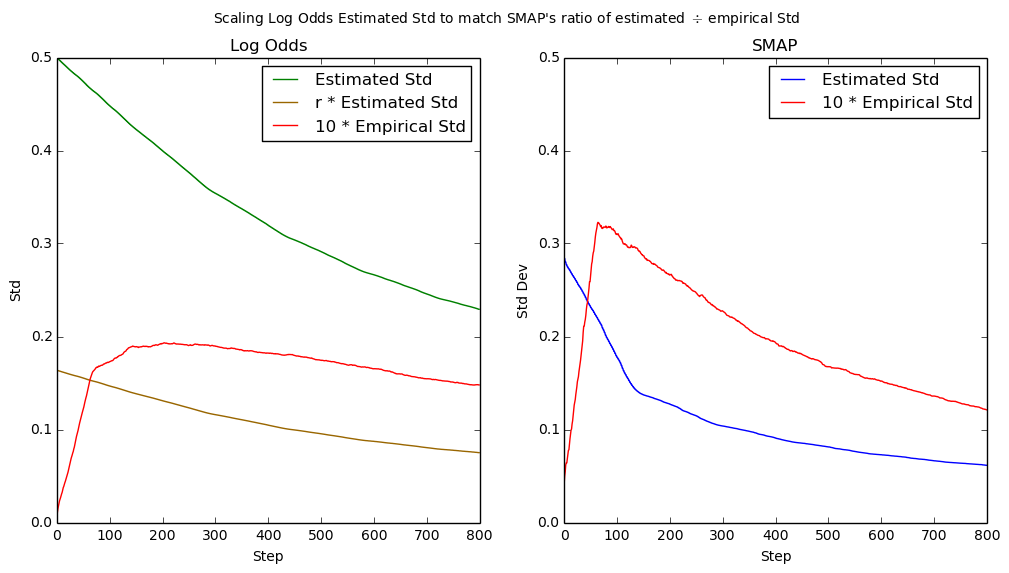

In [23]:
%matplotlib inline
fig, ((ax2, ax3)) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Scaling Log Odds Estimated Std to match SMAP's ratio of estimated $\div$ empirical Std")
ax2.plot(avg_std_logodds, color="g", label="Estimated Std")
ax2.plot(np.array(avg_std_logodds) * scaling_logodds, label="r * Estimated Std", color="#996600")
ax2.plot(np.array(var_err_logodds) * 10., label="10 * Empirical Std", color="r")
ax2.set_xlabel("Step")
ax2.set_ylabel("Std")
ax2.set_title("Log Odds") 
ax2.set_xlim([0, steps])
ax2.set_ylim([0, .5])
ax2.legend()

# ax3.plot(moving_average(var_err_belief), label="SMAP Moving AVG")
# ax3.plot(moving_average(var_err_logodds), label="Log Odds Moving AVG")

ax3.plot(avg_std_belief, color="b", label="Estimated Std")
ax3.plot(np.array(var_err_belief) * 10., label="10 * Empirical Std", color="r")
ax3.set_xlabel("Step")
ax3.set_ylabel("Std Dev")
ax3.set_title("SMAP") 
ax3.set_xlim([0, steps])
ax3.set_ylim([0, .5])
ax3.legend()

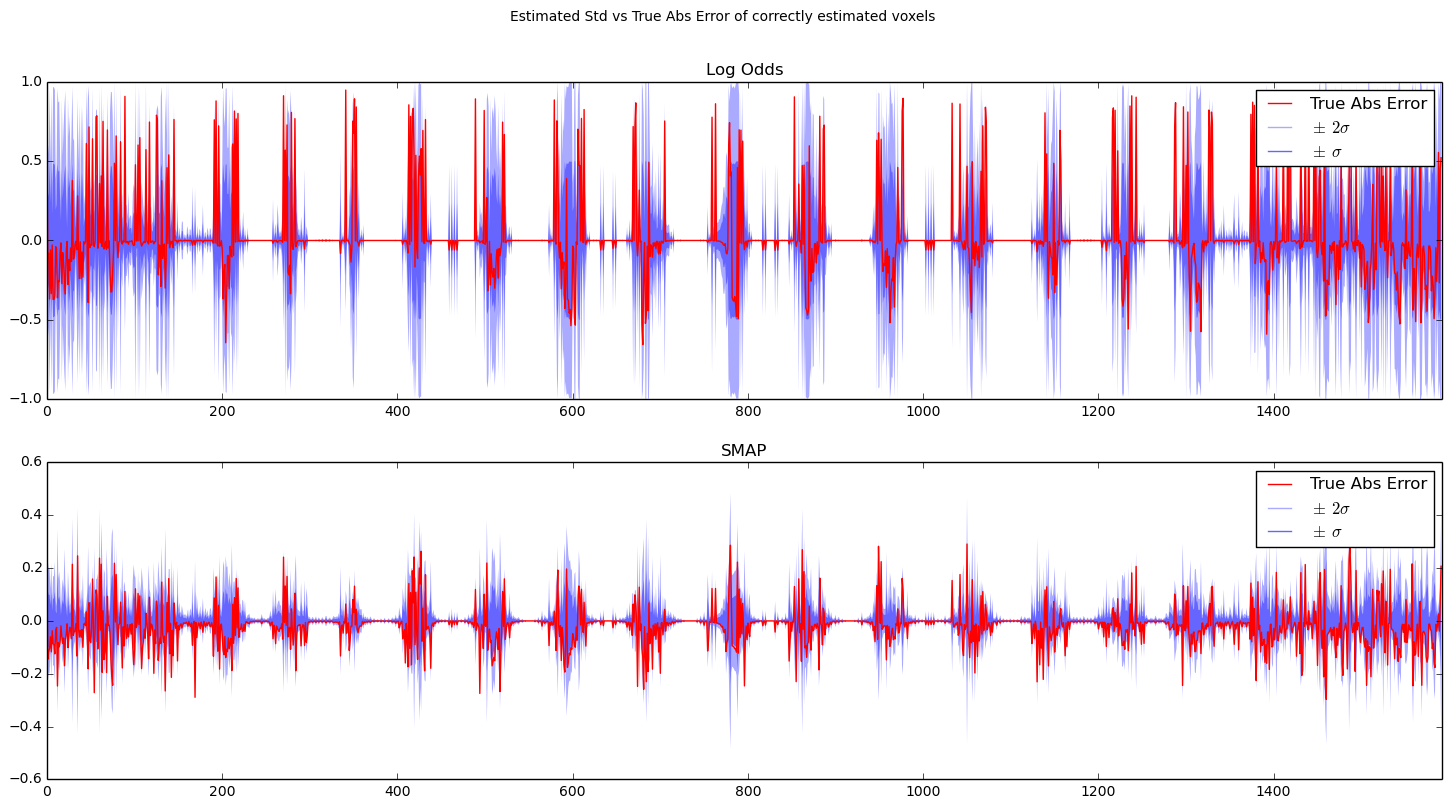

In [7]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 9))
fig.suptitle("Estimated Std vs True Abs Error of correctly estimated voxels")

correct_voxels = len(filter(lambda x: x > 0, mask))
x = list(range(correct_voxels))

ax1.set_title("Log Odds")
stdLogOdds = np.array(last_stats.stdCompleteLogOdds[-voxels:])[mask]
ax1.fill_between(x, -2*stdLogOdds, 2*stdLogOdds, facecolor='#aaaaff', edgecolor='none', antialiased=True)
ax1.fill_between(x, -stdLogOdds, stdLogOdds, facecolor='#6666ff', edgecolor='none', antialiased=True)
ax1.plot(np.array(last_stats.errorCompleteLogOdds[-voxels:])[mask], color="r", label="True Abs Error")
ax1.plot([], color='#aaaaff', label="$\pm\ 2\sigma$")
ax1.plot([], color='#6666ff', label="$\pm\ \sigma$")
ax1.set_xlim([0, correct_voxels])
#ax1.set_ylim([0, 1])
ax1.legend()

ax2.set_title("SMAP")
stdBelief = np.array(last_stats.stdCompleteBelief[-voxels:])[mask]
ax2.fill_between(x, -2*stdBelief, 2*stdBelief, facecolor='#aaaaff', edgecolor='none', antialiased=True)
ax2.fill_between(x, -stdBelief, stdBelief, facecolor='#6666ff', edgecolor='none', antialiased=True)
ax2.plot(np.array(last_stats.errorCompleteBelief[-voxels:])[mask], color="r", label="True Abs Error")
ax2.plot([], color='#aaaaff', label="$\pm\ 2\sigma$")
ax2.plot([], color='#6666ff', label="$\pm\ \sigma$")
ax2.set_xlim([0, correct_voxels])
#ax1.set_ylim([0, 1])
ax2.legend()

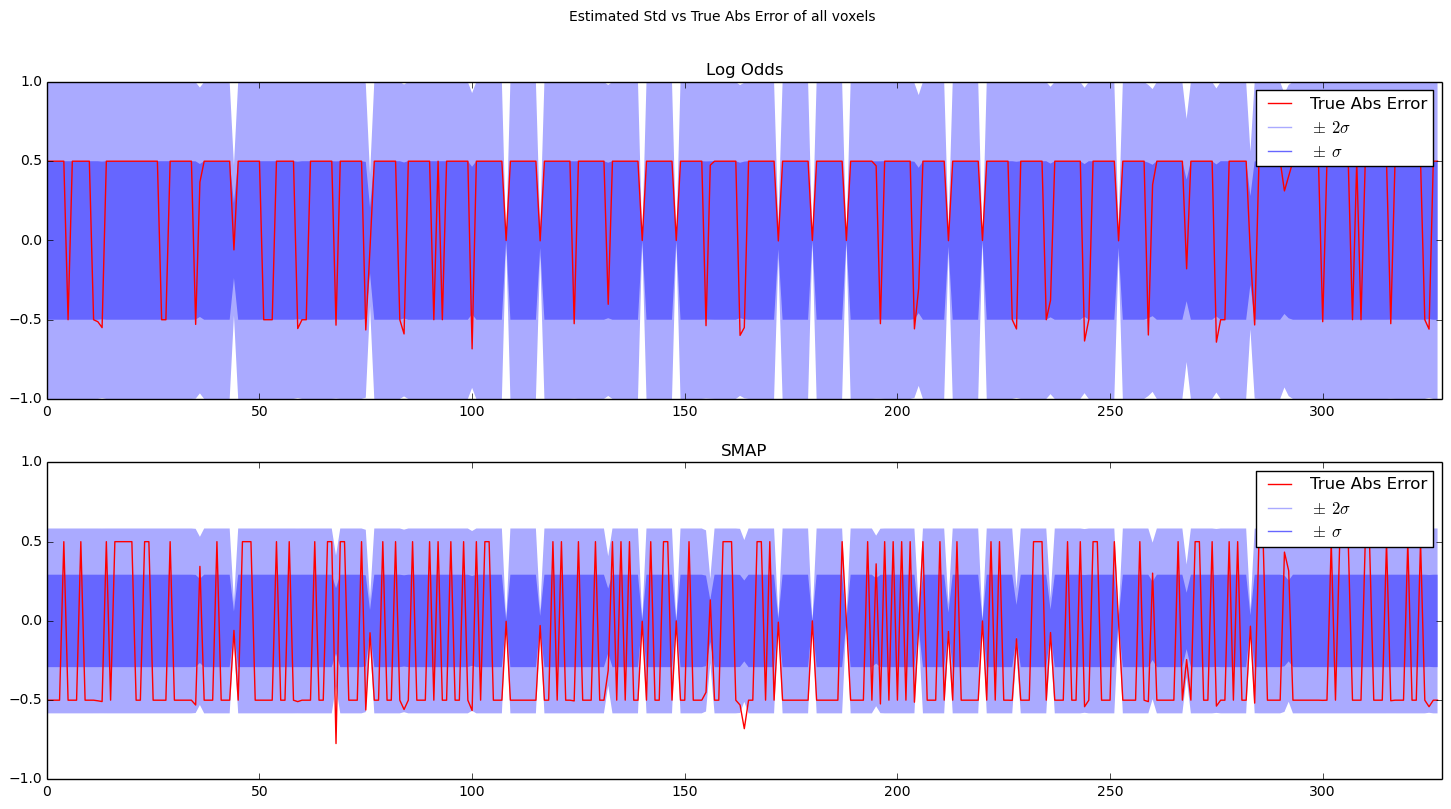

In [8]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 9))
fig.suptitle("Estimated Std vs True Abs Error of all voxels")

stdLogOdds = np.array(last_stats.stdCompleteLogOdds[-voxels:])[::100]
correct_voxels = len(stdLogOdds)
x = list(range(correct_voxels))

ax1.set_title("Log Odds")
stdLogOdds = np.array(last_stats.stdCompleteLogOdds[-voxels:])[::100]
ax1.fill_between(x, -2*stdLogOdds, 2*stdLogOdds, facecolor='#aaaaff', edgecolor='none', antialiased=True)
ax1.fill_between(x, -stdLogOdds, stdLogOdds, facecolor='#6666ff', edgecolor='none', antialiased=True)
ax1.plot(np.array(last_stats.errorCompleteLogOdds[-voxels:])[::100], color="r", label="True Abs Error")
ax1.plot([], color='#aaaaff', label="$\pm\ 2\sigma$")
ax1.plot([], color='#6666ff', label="$\pm\ \sigma$")
ax1.set_xlim([0, correct_voxels])
ax1.set_ylim([-1, 1])
ax1.legend()

ax2.set_title("SMAP")
stdBelief = np.array(last_stats.stdCompleteBelief[-voxels:])[::100]
ax2.fill_between(x, -2*stdBelief, 2*stdBelief, facecolor='#aaaaff', edgecolor='none', antialiased=True)
ax2.fill_between(x, -stdBelief, stdBelief, facecolor='#6666ff', edgecolor='none', antialiased=True)
ax2.plot(np.array(last_stats.errorCompleteBelief[-voxels:])[::100], color="r", label="True Abs Error")
ax2.plot([], color='#aaaaff', label="$\pm\ 2\sigma$")
ax2.plot([], color='#6666ff', label="$\pm\ \sigma$")
ax2.set_xlim([0, correct_voxels])
ax2.set_ylim([-1, 1])
ax2.legend()

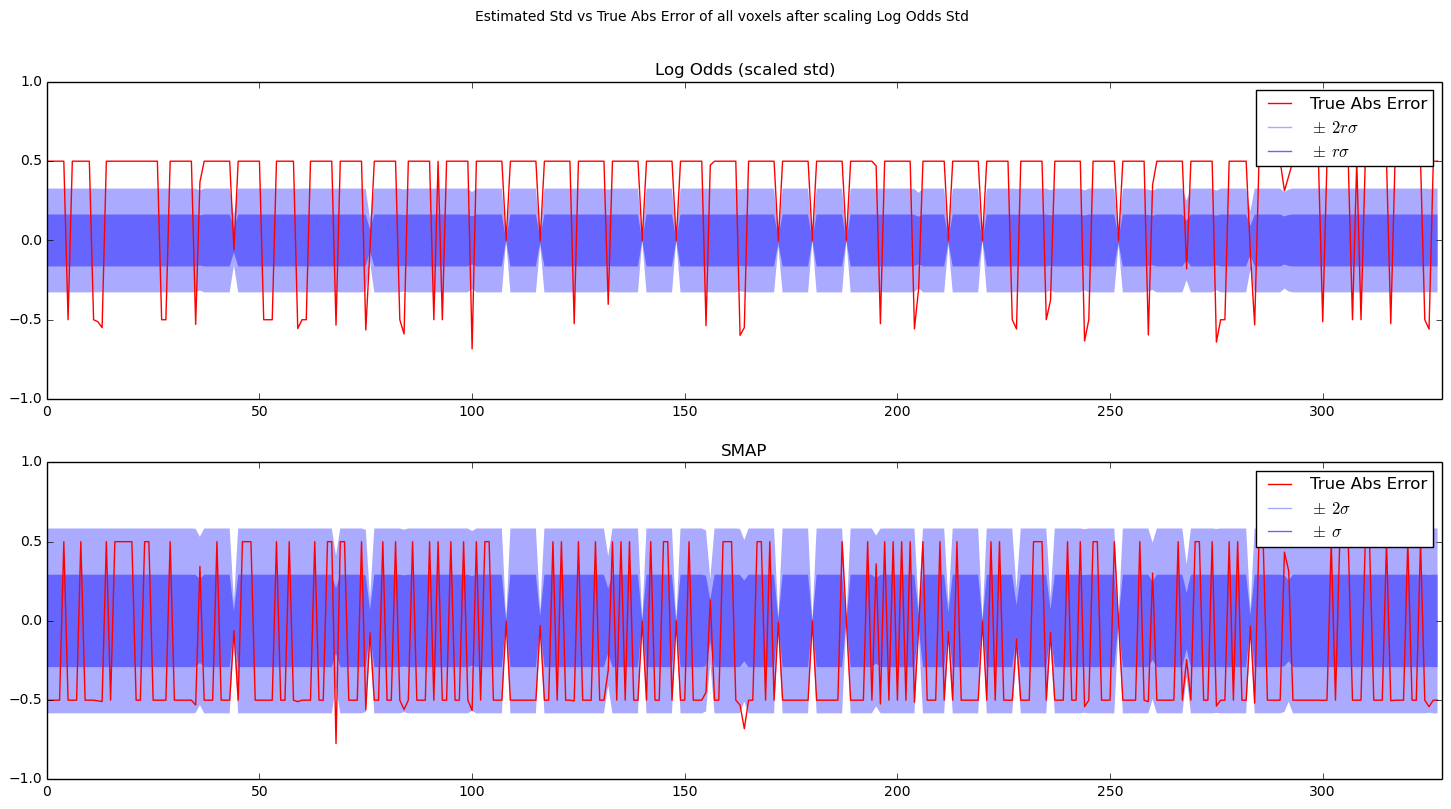

In [9]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 9))
fig.suptitle("Estimated Std vs True Abs Error of all voxels after scaling Log Odds Std")

stdLogOdds = np.array(last_stats.stdCompleteLogOdds[-voxels:])[::100]
correct_voxels = len(stdLogOdds)
x = list(range(correct_voxels))

ax1.set_title("Log Odds (scaled std)")
stdLogOdds = np.array(last_stats.stdCompleteLogOdds[-voxels:])[::100]
ax1.fill_between(x, -2*scaling_logodds*stdLogOdds, 2*scaling_logodds*stdLogOdds, facecolor='#aaaaff', edgecolor='none', antialiased=True)
ax1.fill_between(x, -scaling_logodds*stdLogOdds, scaling_logodds*stdLogOdds, facecolor='#6666ff', edgecolor='none', antialiased=True)
ax1.plot(np.array(last_stats.errorCompleteLogOdds[-voxels:])[::100], color="r", label="True Abs Error")
ax1.plot([], color='#aaaaff', label="$\pm\ 2r\sigma$")
ax1.plot([], color='#6666ff', label="$\pm\ r\sigma$")
ax1.set_xlim([0, correct_voxels])
ax1.set_ylim([-1, 1])
ax1.legend()

ax2.set_title("SMAP")
stdBelief = np.array(last_stats.stdCompleteBelief[-voxels:])[::100]
ax2.fill_between(x, -2*stdBelief, 2*stdBelief, facecolor='#aaaaff', edgecolor='none', antialiased=True)
ax2.fill_between(x, -stdBelief, stdBelief, facecolor='#6666ff', edgecolor='none', antialiased=True)
ax2.plot(np.array(last_stats.errorCompleteBelief[-voxels:])[::100], color="r", label="True Abs Error")
ax2.plot([], color='#aaaaff', label="$\pm\ 2\sigma$")
ax2.plot([], color='#6666ff', label="$\pm\ \sigma$")
ax2.set_xlim([0, correct_voxels])
ax2.set_ylim([-1, 1])
ax2.legend()

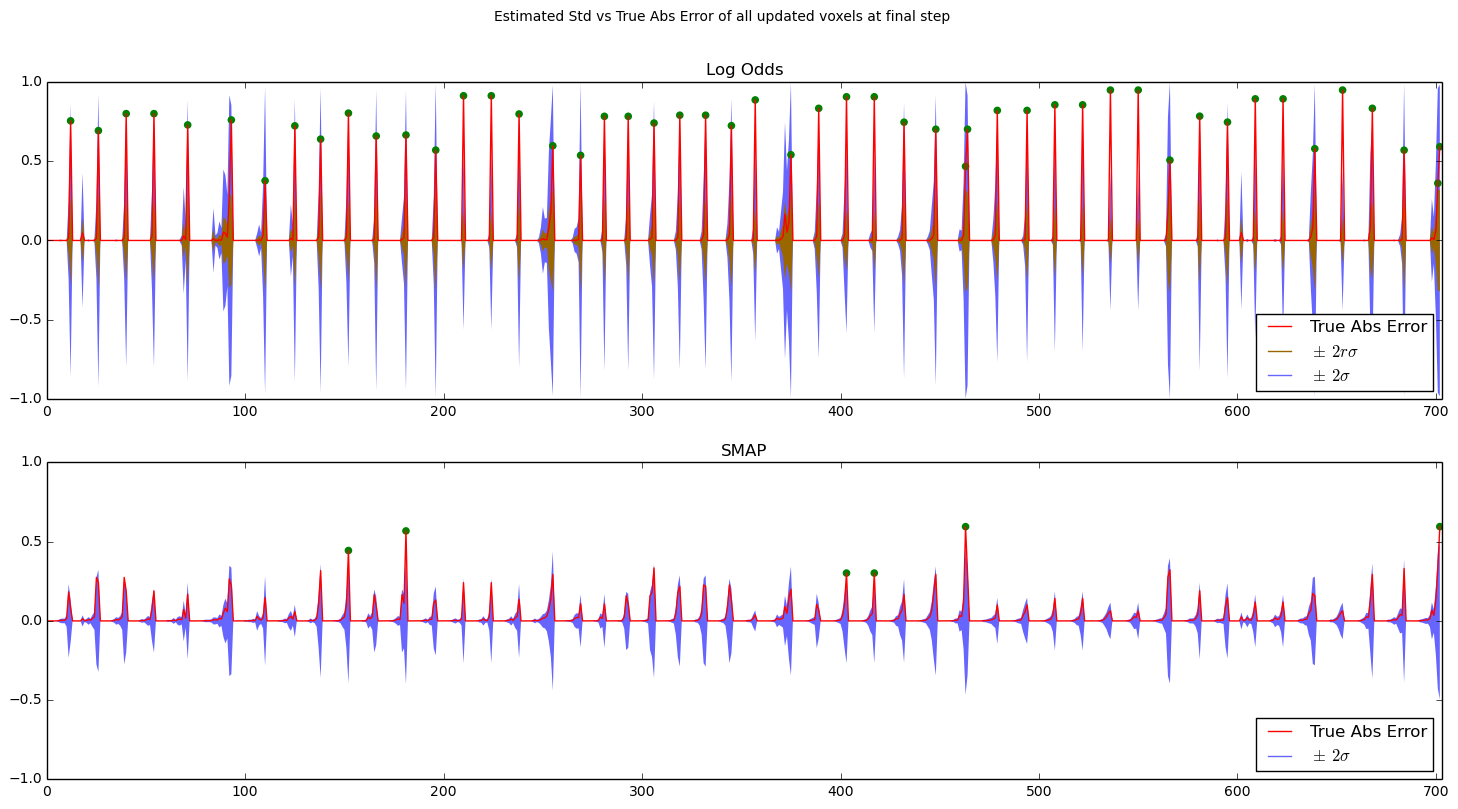

In [10]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 9))
fig.suptitle("Estimated Std vs True Abs Error of all updated voxels at final step")

stdLogOdds = np.array(last_stats.stdCompleteUpdatedLogOdds[-last_stats.updatedVoxels[-1]:])[::1]
correct_voxels = len(stdLogOdds)
x = np.array(list(range(correct_voxels)))

factor = (var_err_logodds[-1]/avg_std_logodds[-1]) * 15.
ax1.set_title("Log Odds")
stdLogOdds = np.array(last_stats.stdCompleteUpdatedLogOdds[-last_stats.updatedVoxels[-1]:])[::1]
errLogOdds = np.array(last_stats.errorCompleteUpdatedLogOdds[-last_stats.updatedVoxels[-1]:])[::1]
new_mask = np.abs(errLogOdds) > scaling_logodds * 2 * stdLogOdds
ax1.fill_between(x, -2*stdLogOdds, 2*stdLogOdds, facecolor='#6666ff', edgecolor='none', antialiased=True)
ax1.fill_between(x, -2*scaling_logodds*stdLogOdds, 2*scaling_logodds*stdLogOdds, facecolor='#996600', edgecolor='none', antialiased=True)
ax1.plot(errLogOdds, color="r", label="True Abs Error")
ax1.plot([], color='#996600', label="$\pm\ 2r\sigma$")
ax1.plot([], color='#6666ff', label="$\pm\ 2\sigma$")
ax1.scatter(x[new_mask], errLogOdds[new_mask], color="g")
ax1.set_xlim([0, correct_voxels])
ax1.set_ylim([-1, 1])
ax1.legend(loc="lower right")

ax2.set_title("SMAP")
stdBelief = np.array(last_stats.stdCompleteUpdatedBelief[-last_stats.updatedVoxels[-1]:])[::1]
errBelief = np.array(last_stats.errorCompleteUpdatedBelief[-last_stats.updatedVoxels[-1]:])[::1]
new_mask = np.abs(errBelief) > 2 * stdBelief
ax2.fill_between(x, -2*stdBelief, 2*stdBelief, facecolor='#6666ff', edgecolor='none', antialiased=True)
ax2.plot(errBelief, color="r", label="True Abs Error")
ax2.plot([], color='#6666ff', label="$\pm\ 2\sigma$")
ax2.scatter(x[new_mask], errBelief[new_mask], color="g")
ax2.set_xlim([0, correct_voxels])
ax2.set_ylim([-1, 1])
ax2.legend(loc="lower right")

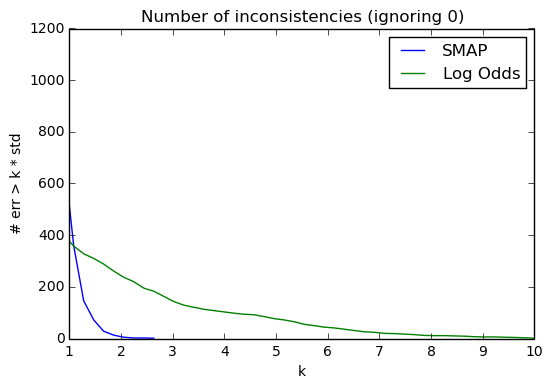

In [18]:
%matplotlib inline
plt.title("Number of inconsistencies (ignoring 0)")

stdLogOdds = np.array(last_stats.stdCompleteLogOdds[-voxels:])[mask]
stdBelief = np.array(last_stats.stdCompleteBelief[-voxels:])[mask]
errLogOdds = np.array(last_stats.errorCompleteLogOdds[-voxels:])[mask]
errBelief = np.array(last_stats.errorCompleteBelief[-voxels:])[mask]
correct_voxels = len(stdLogOdds)
ks = list(np.linspace(.5, 10, 50))

inconsistencies_belief = []
inconsistencies_logodds = []
for k in ks:
    inconsistencies_belief.append(len(list(filter(lambda x: x > 0, list(np.abs(errBelief) > k * stdBelief)))))
    inconsistencies_logodds.append(len(list(filter(lambda x: x > 0, list(np.abs(errLogOdds) > k * scaling_logodds * stdLogOdds)))))

inconsistencies_belief = np.array(inconsistencies_belief)
inconsistencies_logodds = np.array(inconsistencies_logodds)
ks = np.array(ks)

plt.plot(ks[inconsistencies_belief>0], inconsistencies_belief[inconsistencies_belief>0], color="b", label="SMAP")
plt.plot(ks[inconsistencies_logodds>0], inconsistencies_logodds[inconsistencies_logodds>0], color="g", label="Log Odds")
plt.legend(loc="upper right")
plt.xlim([1, np.max(ks)])
plt.xlabel("k")
plt.ylabel("# err > k * std")

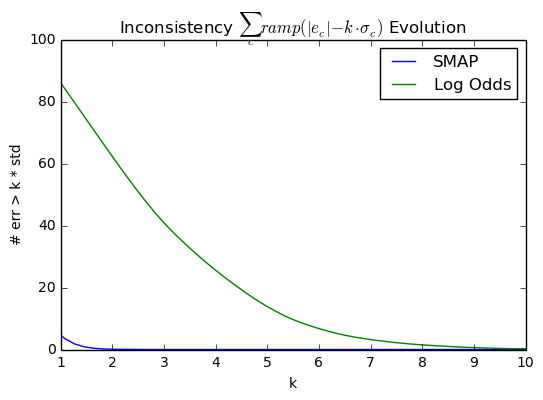

In [19]:
%matplotlib inline
plt.title("Inconsistency $\sum_c ramp(|e_c|-k\cdot \sigma_c)$ Evolution")

#stdLogOdds = np.array(last_stats.stdCompleteUpdatedLogOdds[-last_stats.updatedVoxels[-1]:])[::1]
correct_voxels = len(stdLogOdds)

inconsistencies_belief = []
inconsistencies_logodds = []
for k in ks:
    inconsistencies_belief.append(
        np.sum([max(0, err - k * std) for err, std in zip(errBelief, stdBelief)]))
    inconsistencies_logodds.append(
        np.sum([max(0, err - k * scaling_logodds * std) for err, std in zip(errLogOdds, stdLogOdds)]))

inconsistencies_belief = np.array(inconsistencies_belief)
inconsistencies_logodds = np.array(inconsistencies_logodds)

plt.plot(ks, inconsistencies_belief, color="b", label="SMAP")
plt.plot(ks, inconsistencies_logodds, color="g", label="Log Odds")
plt.legend(loc="upper right")
plt.xlim([1, np.max(ks)])
plt.xlabel("k")
plt.ylabel("# err > k * std")

In [ ]:
def correct(std, err):
    minStd = np.min(std)
    maxStd = np.max(std)
    dStd = maxStd - minStd
    print "std params: ", minStd, maxStd
    minErr = np.min(err)
    maxErr = np.max(err)
    dErr = maxErr - minErr
    print "err params: ", minErr, maxErr

    newStd = (std  - minStd) * dErr / dStd + minErr
    minNew = np.min(newStd)
    maxNew = np.max(newStd)
    print "new params: ", minNew, maxNew

    return newStd

%matplotlib inline
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 9))
fig.suptitle("Empirical Variance of True Error and Estimated Std at Correctly Predicted Voxels (True Error < 0.3)")

correct_voxels = len(filter(lambda x: x > 0, mask))

ax1.set_title("Log Odds")
ax1.plot(np.abs(np.array(last_stats.errorCompleteLogOdds[-voxels:])[mask]), color="r", label="True Abs Error")
ax1.plot(2. * (np.array(last_stats.stdCompleteLogOdds[-voxels:])[mask]), color="b", label="2 * Std")
ax1.set_xlim([0, correct_voxels])
ax1.set_ylim([0, 1])
ax1.legend()

ax2.set_title("SMAP")
ax2.plot(np.abs(np.array(last_stats.errorCompleteBelief[-voxels:])[mask]), color="r", label="True Abs Error")
ax2.plot(2. * (np.array(last_stats.stdCompleteBelief[-voxels:])[mask]), color="b", label="2 * Std")
ax2.set_xlim([0, correct_voxels])
ax2.set_ylim([0, 1])
ax2.legend()

In [ ]:
plt.plot([np.mean([np.std([err_belief[rnd][_s][voxeli]  for rnd in range(len(filenames))])  for voxeli in range(1000)
         ]) for _s in range(0, 295)])
plt.plot([np.mean([np.std([err_logodds[rnd][_s][voxeli]  for rnd in range(len(filenames))])  for voxeli in range(1000)
         ]) for _s in range(0, 295)])